# Hemisphere Macroregions Test Notebook

This notebook generates a hemisphere volume with warped macroregions and saves it as an N5 file.

## Setup
Import necessary libraries and define the `add_macroregions` helper function.

In [22]:

!pip install z5py
import numpy as np
from scipy.ndimage import gaussian_filter
import z5py

import numpy as np
from scipy.ndimage import gaussian_filter

def add_macroregions(labels, macro_regions, region_smoothness, gradient_axis=1):
    """
    Brainier macroregions: threshold a 3D smooth noise field.
    
    Parameters
    ----------
    labels : np.ndarray, shape (Z,Y,X)
        preallocated label array (will be overwritten for macroregions).
    macro_regions : int
        how many regions to carve out.
    region_smoothness : float
        Gaussian σ for 3D smoothing of the random field.
    gradient_axis : int (0,1,2)
        add a linear gradient along this axis to bias region shapes
        (e.g. cortical layers along Y axis=1).
    """
    nz, ny, nx = labels.shape
    rng = np.random.default_rng()
    # 1) make a raw 3D noise volume
    noise3d = rng.random((nz, ny, nx), dtype=np.float32)
    # 2) smooth it heavily
    smooth3d = gaussian_filter(noise3d, sigma=region_smoothness)
    
    # 3) optionally add a gentle planar gradient to encourage layering
    if gradient_axis is not None:
        coords = np.arange(labels.shape[gradient_axis], dtype=np.float32)
        coords = (coords - coords.mean()) / np.ptp(coords)
        # broadcast into full volume
        if gradient_axis == 0:
            smooth3d += coords[:, None, None] * 0.3
        elif gradient_axis == 1:
            smooth3d += coords[None, :, None] * 0.3
        else:
            smooth3d += coords[None, None, :] * 0.3
    
    # 4) compute quantile thresholds
    #    we skip the very bottom and top to avoid tiny scraps
    qs = np.linspace(0, 1, macro_regions+1)
    # trim 1–2% at extremes if you like: qs = np.clip(qs, 0.02, 0.98)
    thresholds = np.quantile(smooth3d, qs)
    
    # 5) assign labels 1..macro_regions by binning smooth3d
    for i in range(macro_regions):
        lo, hi = thresholds[i], thresholds[i+1]
        mask = (smooth3d >= lo) & (smooth3d < hi)
        labels[mask] = i+1
    
    return labels


ERROR: Could not find a version that satisfies the requirement z5py (from versions: none)
ERROR: No matching distribution found for z5py


## Parameters
Define volume dimensions and macroregion parameters.

In [23]:

# Parameters
n_slices = 200
ny, nx = 200, 200
macro_regions = 10
region_smoothness = 25
voxel_size = [1.0, 1.0, 1.0]


## Generate Hemisphere and Macroregions

In [24]:
# 1) Create empty label volume
labels = np.zeros((n_slices, ny, nx), dtype=np.uint8)

# 2) Build hemisphere mask
cz, cy, cx = n_slices//2, ny//2, nx//2
R = min(cz, cy, cx)
zz, yy, xx = np.ogrid[:n_slices, :ny, :nx]
sphere     = (zz-cz)**2 + (yy-cy)**2 + (xx-cx)**2 <= R**2
hemisphere = sphere & (zz >= cz)

# 3) Initialize hemisphere to “background”=1
labels[hemisphere] = 1

# 4) Carve brain-like macroregions **only inside** the hemisphere
#    We'll make a temp array of the same shape, fill it, then mask
tmp = np.zeros_like(labels, dtype=np.uint8)
tmp[hemisphere] = 1                        # init inside hemisphere
tmp = add_macroregions(tmp, macro_regions, region_smoothness, gradient_axis=1)

# 5) Copy back into labels, zeroing outside
labels[hemisphere] = tmp[hemisphere]
labels[~hemisphere] = 0


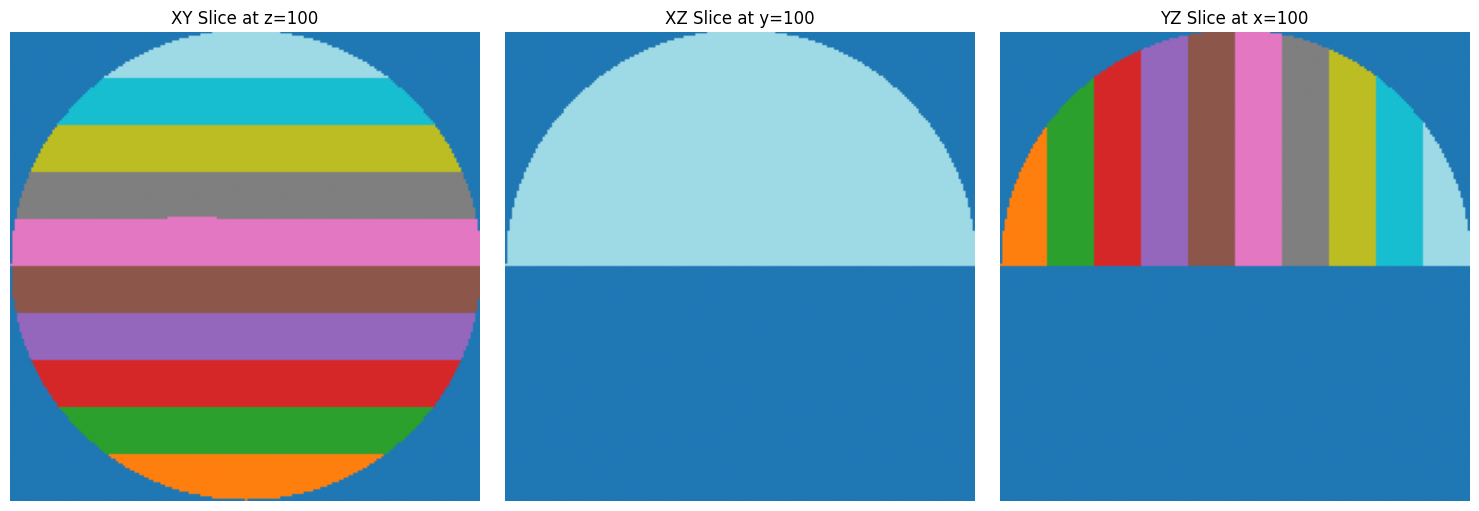

In [21]:
import matplotlib.pyplot as plt

# Choose slices
z_slice = cz
y_slice = cy
x_slice = cx

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(labels[z_slice], cmap='tab20', origin='lower')
axes[0].set_title(f'XY Slice at z={z_slice}')
axes[1].imshow(labels[:, y_slice, :], cmap='tab20', origin='lower')
axes[1].set_title(f'XZ Slice at y={y_slice}')
axes[2].imshow(labels[:, :, x_slice], cmap='tab20', origin='lower')
axes[2].set_title(f'YZ Slice at x={x_slice}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Save to N5

In [ ]:

# Save to N5
out = z5py.File("/mnt/data/hemisphere_macroregions.n5", use_zarr_format=False)
out.create_dataset("labels", data=labels, chunks=(32,32,32), compression="raw")
print("Saved hemisphere with macro-regions to /mnt/data/hemisphere_macroregions.n5")
